## Spatial Autocorrelation: location and price
Spatial autocorrelation is used to find if there exist a relation between a variable of interest in a given location, and the values of the same variable in the surroundings. 
We would like to understand whether there exist such relation with respect to the price of the AirBnB structures (our variable of interest), or if there is spatial randomness, namely there is no correlation between the location of the structure and its price. 

Moreover, in the case of spatial autocorrelation, we would like to find out whether this relation is positive or negative, as this gives important additional information. Indeed, if there exist positive spatial autocorrelation, it means that structures with similar values of the price tend to form clusters and have a similar location. On the other hand, if the autocorrelation is negative, AirBnB with similar values of the price will tend to be further away from each other.

In order to understand better this relation, we will firstly analyse global spatial autocorrelation of the price using the Moran's I index, which gives a measure of the association between our variable of interest and its spatial lag, under the assumptions of normality and randomization. The range of the Moran's I index goes from -1 to +1, where values close to the extremes imply, respectively, negative and positive correlation, while values close to zero suggest the absence of it. 

Finally, in order to assess for local patterns, we will look for local spatial clusters using the Moran's scatterplot and the local Moran's I.

In [ ]:
try:
  import geopandas as gpd
except ModuleNotFoundError as e:
  !pip install geopandas==0.10.1
  import geopandas as gpd

if gpd.__version__ != "0.10.1":
  !pip install -U geopandas==0.10.1
  import geopandas as gpd

In [ ]:
try:
  import contextily 
except ModuleNotFoundError as e:
  !pip install contextily==1.1.0
  import contextily

if contextily.__version__ != "1.1.0":
  !pip install -U contextily==1.1.0
  import contextily 

In [ ]:
try:
  import pysal
except ModuleNotFoundError as e:
  !pip install pysal==2.5.0
  import pysal

if gpd.__version__ != "2.5.0":
  !pip install -U pysal==2.5.0
  import pysal

In [ ]:
import pandas as pd
import numpy as np
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
import pysal
from pysal.lib import weights
from libpysal.weights.util import min_threshold_distance
from pysal.explore import esda
from pysal.model import spreg
from splot.esda import plot_moran
import seaborn

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)
/usr/local/lib/python3.7/dist-packages/spaghetti/network.py:36: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(f"{dep_msg}", FutureWarning)


In [ ]:
import os
import sys 
from google.colab import drive 
import glob

path = "/content/drive" 
drive.mount(path, force_remount=True)  
data_path = "drive/MyDrive/Colab Notebooks/Geosp_prj" 

myfiles = glob.glob(os.path.join(data_path, '*')) 
print(myfiles) 

Mounted at /content/drive
['drive/MyDrive/Colab Notebooks/Geosp_prj/listings.csv', 'drive/MyDrive/Colab Notebooks/Geosp_prj/neighbourhoods.geojson', 'drive/MyDrive/Colab Notebooks/Geosp_prj/wu2013poi.json', 'drive/MyDrive/Colab Notebooks/Geosp_prj/output.json', 'drive/MyDrive/Colab Notebooks/Geosp_prj/PoI_Trentino.csv', 'drive/MyDrive/Colab Notebooks/Geosp_prj/airbnb-logo.png', 'drive/MyDrive/Colab Notebooks/Geosp_prj/resized_airbnb_logo.png', 'drive/MyDrive/Colab Notebooks/Geosp_prj/InsideAirBnB.ipynb', 'drive/MyDrive/Colab Notebooks/Geosp_prj/SpatialStatisticalAnalysis.ipynb']


In [ ]:
# InsideAirBnB data
data = pd.read_csv(data_path+'/listings.csv')
data = gpd.GeoDataFrame(data, crs='EPSG:4326', geometry=gpd.points_from_xy(data.longitude, data.latitude))
data.head(2)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license,geometry
0,37736,Charming cozy apartment North Italy,162348,Daniele,NaN,Trentino,46.43409,11.10201,Entire home/apt,58,7,79,2019-07-03,0.75,4,331,9,NaN,POINT (11.10201 46.43409)
1,56292,Central apartment located on the ski slopes,266605,Stefano,NaN,Trentino,46.23199,10.82732,Entire home/apt,90,7,6,2019-02-09,0.10,1,344,2,022143-AT-060406,POINT (10.82732 46.23199)


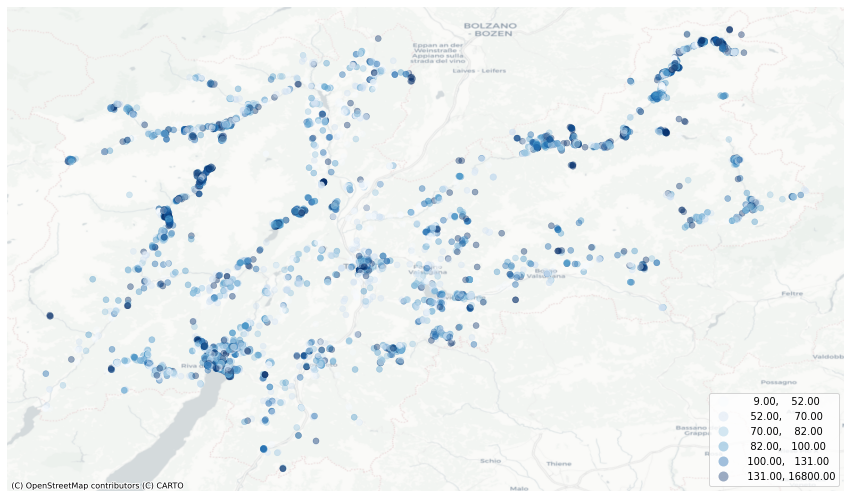

In [ ]:
# plot the data

fig, ax = plt.subplots(1, figsize=(15, 15)) 

data.to_crs(epsg=4326).plot(column="price",
                    alpha=.4, cmap="Blues", 
                    legend=True, linewidth = 0.5,
                    scheme="quantiles", k=6, 
                    ax=ax)

ctx.add_basemap(ax, crs=data.to_crs(epsg=4326).crs.to_string(),
                source=ctx.providers.CartoDB.Positron)

ax.set_axis_off()

### Spatial weight matrix
Before doing the computations stated above, we need to compute the spatial weight matrix. Given that we are dealing with points, we can only use k-nn criterion or the critical cut-off criterion, as contiguity-based approach can only be applied to polygons. 

The k-nn approach implies that two spatial units are neighbours if their distance is the minimum possible distance that can be found among all observations. This criterion requires that the number of k-neighbours is chosen in advance and the k points with minimum distance from the considered observation will be the neighbours, which means all points will have the same number of neighbours.

In [ ]:
W_knn = weights.KNN.from_dataframe(data, k=7) 

In [ ]:
# row-standardize the matrix
W_knn.transform = 'R'

The critical cut-off approach implies two spatial units are neighbours if their distance is equal to a previously fixed threshold. This threshold should never be smaller than the minimum value ensuring each units has at least one neighbour.

In [ ]:
coords = []

for row in range(len(data)):
  c = [data.at[row, 'latitude'], data.at[row, 'longitude']]
  coords.append(c)

coords = np.array(coords)

In [ ]:
threshold = min_threshold_distance(coords)
threshold

0.05411727358246904

In [ ]:
W_threshold = weights.DistanceBand.from_dataframe(data, threshold=threshold, binary=False)

In [ ]:
# row-standardize the matrix
W_threshold.transform = 'R'

### Spatial lag
The spatial lag is the product between the spatial weight matrix and the variable of interest and, if the weight matrix is row-standardized, the result will be the average value of the variable of interest in the area surrounding the considered observation.
This means that, in our case, the spatial lag will define the average value of the price of AirBnB among the neighbours of each point. 
Note that, depending on which weight matrix we use, this average (the spatial lag) will be different.

In [ ]:
data['spatial_lag_W_knn'] = weights.lag_spatial(W_knn, data['price'])
data['spatial_lag_W_threshold'] = weights.lag_spatial(W_threshold, data['price'])

In [ ]:
data.head(2)

,index,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license,geometry,spatial_lag_W_knn,spatial_lag_W_threshold,price_std,spatial_lag_W_threshold_std,significant,quadrant
0,19,700213,Trento Center B&B Rosagalina,3592127,Sybille,NaN,"Trento, Trentino",46.06475,11.13196,Entire home/apt,53,2,45,2018-09-08,0.41,2,332,5,NaN,POINT (11.13196 46.06475),107.6,95.089046,-0.199117,-0.003003,False,3
1,44,1252024,"Superb view, close to city centre",6821775,Chiara,NaN,"Trento, Trentino",46.07468,11.12953,Entire home/apt,120,2,16,2021-10-16,0.21,3,230,3,NaN,POINT (11.12953 46.07468),80.2,86.977564,0.113070,-0.040798,False,4


### Moran's I 

In [ ]:
moran_threshold = esda.moran.Moran(data['price'], W_threshold)

In [ ]:
moran_knn = esda.moran.Moran(data['price'], W_knn)

In [ ]:
# Moran's I value
moran_threshold.I, moran_knn.I 

(0.02146343888685742, 0.03528846730287081)

In [ ]:
# p-values
moran_threshold.p_sim, moran_knn.p_sim

(0.001, 0.004)

The Moran's I is close to zero in both cases, thus one would conclude there is no spatial autocorrelation, and according to the p-values this result is significant. Nevertheless, as computed below, one can notice that both Moran's I results are higher than the expected value under the null hyphotesis of no spatial autocorrelation.

In [ ]:
# Under the null hypothesis of no spatial autocorrelation, 
# we would expect a Moran's index equal to -1/(N-1)
N = len(data)
expected_I = -1/(N-1)
expected_I

-0.00016215339711366953

Even though the two weight matrices return two different probabilities, both the p-values are lower than 5%, which is a common threshold for significance. This means that the results obtained are indeed significant. 
The value of the Moran's I index suggest there is basically no global autocorrelation between the location of Trento AirBnB and their prices, as the value approaches zero, where the autocorrelation is null. It is likely that other factors are more important for setting the price, such as minimum stay and the size of the apartment, nevertheless this result is still higher than the expected one.

We may also visualize what we just said using the following line of code.
In the plot below, it is possible to see a panel on the left showing an empirical distribution generated by 999 random simulations of the map with respect to the "price" variable and then computing the corresponding Moran's I each time. On the base of the distribution there are two tiny ticks: the blue vertical tick indicates the mean of the distribution, namely the average value of the randomly obtained Moran's I, while the red one, on the right part of the plot, shows the Moran’s I calculated for the price using the geography observed in the dataset. 
As previously noticed, the observed value is higher than what would be obtained under randomness, nevertheless the difference is extremely low in strength.

The plot on the right shows the variable of interest (the price) plotted against its spatial lag. This plot is called Moran's plot as the Moran's I can be seen as the slope of the line. 

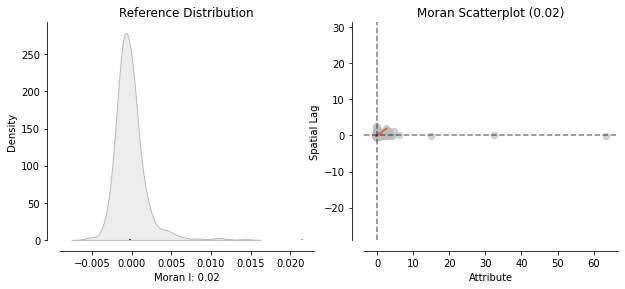

In [ ]:
plot_moran(moran_threshold); # using the Moran's I obtained with critical cut-off weight matrix

Moran's plot can also be obtained as follows:

In [ ]:
# standardize the price variable and compute spatial lag on standardized variable
data['price_std'] = ( data['price'] - data['price'].mean() ) / data['price'].std()
# data['spatial_lag_W_knn_std'] = weights.lag_spatial(W_knn, data['price_std'])
data['spatial_lag_W_threshold_std'] = weights.lag_spatial(W_threshold, data['price_std'])

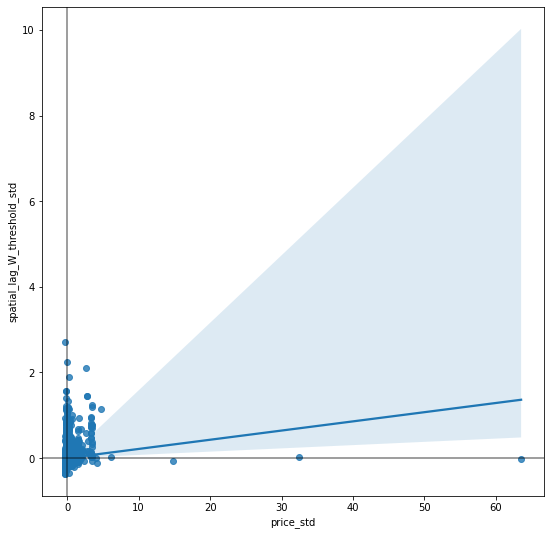

In [ ]:
# Moran's plot
f, ax = plt.subplots(1, figsize=(9, 9))

seaborn.regplot(x='price_std', y='spatial_lag_W_threshold_std', data=data)

plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
plt.show()

From the Moran's plot it seems like few observations are actually changing the slope of the line (namely the Moran's I) quite a lot.

### Local spatial autocorrelation
Local spatial autocorrelation allows to discover the presence of local spatial clusters, which are not captured by the global measure of Moran's I.

The Moran scatterplot is used for this purpose. It plots the variable of interest on the horizontal axis and the spatial lag on the vertical one.
The resulting plot has four quadrants, which define four different types of spatial association.
The HH (high-high) quadrant defines a region with value of x (in our case the price) and corresponding spatial lags both above the average. Similarly, the LL (low-low) quadrant identifies a region with value of the price and of the spatial lag below the average.
The values falling in these two quadrants are said to be defined by positive spatial autocorrelation since they are surrounded by neighbours with similar values.
The other two quadrants (LH - low-high, and HL - high-low) are charachterized by negative autocorrelation since they identify regions with low value of the price and high spatial lag, or viceversa high price and low spatial lag. This means that these observations are surrounded by neighbours with dissimilar values of the variable of interest.

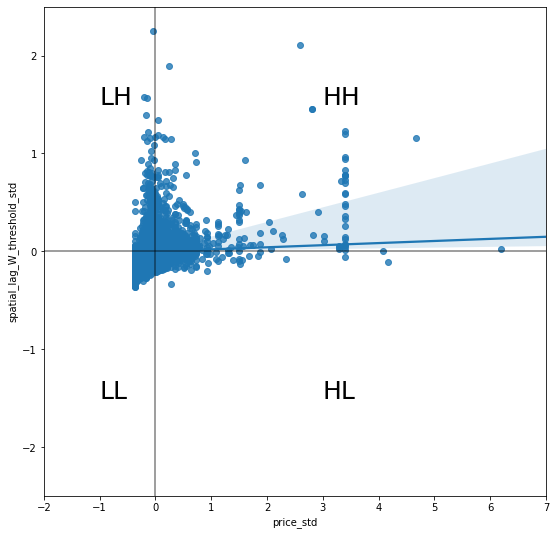

In [ ]:
f, ax = plt.subplots(1, figsize=(9, 9))

# using critical cut-off distance for the weight matrix
seaborn.regplot(x='price_std', y='spatial_lag_W_threshold_std', data=data)


plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
ax.set_xlim(-2, 7)
ax.set_ylim(-2.5, 2.5)

plt.text(3, 1.5, "HH", fontsize=25)
plt.text(3, -1.5, "HL", fontsize=25)
plt.text(-1, 1.5, "LH", fontsize=25)
plt.text(-1, -1.5, "LL", fontsize=25)


plt.show()

To test whether the concentration of observations in each quadrants is significant, we need to compare it with how much this distribution is different from what we would obtain from a random process.

In [ ]:
local_moran = esda.Moran_Local(data['price'].values, W_threshold)

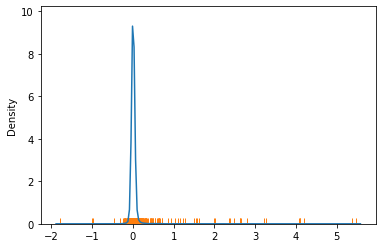

In [ ]:
# distribution of the local moran
ax = seaborn.kdeplot(local_moran.Is)
seaborn.rugplot(local_moran.Is, ax=ax)

The values on the left tail of the density represent locations displaying negative spatial association, namely a high price observation surrounded by AirBnB having low prices, or a low price structure surrounded by high price neighboring observations. On the right tail, there are instead observations showing positive spatial association, namely high price surrounded by structures with high prices, or low prices structures surrounded by similar neighbours. The center of the distribution is instead associated with no local autocorrelation.

In order to consider only significant relationships, we produce a plot that considers only the observations that are unlikely to result from a random process (the significant ones, with p-value lower than 5%) and color them
differently according to the quadrant (cluster) they belong to.

In [ ]:
# p-values (significant if < 0.05)
local_moran.p_sim

array([0.066, 0.035, 0.056, ..., 0.097, 0.151, 0.389])

In [ ]:
# quadrants
local_moran.q # HH -> 1; LH -> 2; LL -> 3; HL -> 4

array([3, 2, 1, ..., 2, 1, 4])

In [ ]:
# Boolean column -> true if significant (5% threshold)
data['significant'] = local_moran.p_sim < 0.05
# Column with quadrants of belonging (for clustering)
data['quadrant'] = local_moran.q

In [ ]:
print('HH: ', len(data[data.quadrant==1]))
print('LH: ', len(data[data.quadrant==2]))
print('LL: ', len(data[data.quadrant==3]))
print('HL: ', len(data[data.quadrant==4]))

HH:  1007
LH:  1459
LL:  2968
HL:  734


Summed up, the values leading to positive spatial association (HH and LL) are the greatest in number.

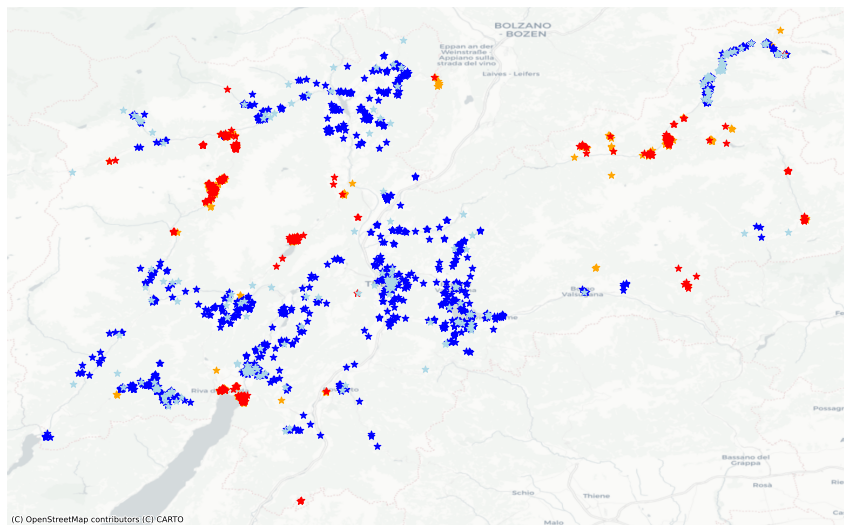

In [ ]:
fig, ax = plt.subplots(1, figsize=(15, 15)) 

# plot HH 
# HH observations (in orange) are AirBnB with "unusual"  high value (above the average) of the 
# price, surrounded by similar AirBnB, namely characterized by high prices as well.
hh = data.loc[(data['quadrant']==1) & (data['significant']==True), 'geometry']
hh.to_crs(epsg=4326).plot(marker='*', color='orange', markersize=50, ax=ax)

# plot LL 
# LL observation (in blue) are AirBnB characterized by unusual low prices (below the average)
# and surrounded by other similar AirBnB.
# The greatest majority among the significant observations belong to this cluster.
ll = data.loc[(data['quadrant']==3) & (data['significant']==True), 'geometry']
ll.to_crs(epsg=4326).plot(marker='*', color='blue', markersize=50, ax=ax)

# plot LH (in red)
# AirBnB with low prices surrounded by others with high prices (spatial outliers)
lh = data.loc[(data['quadrant']==2) & (data['significant']==True), 'geometry']
lh.to_crs(epsg=4326).plot(marker='*', color='red', markersize=50, ax=ax)

# plot HL (in light blue)
# AirBnB with high prices surrounded by others with low prices (spatial outliers)
hl = data.loc[(data['quadrant']==4) & (data['significant']==True), 'geometry']
hl.to_crs(epsg=4326).plot(marker='*', color='lightblue', markersize=50, ax=ax)

# basemap
ctx.add_basemap(ax, crs=data.to_crs(epsg=4326).crs.to_string(),
                source=ctx.providers.CartoDB.Positron)

ax.set_axis_off()


In [ ]:
print('Significant:')
print('HH: ', len(data[(data.quadrant==1)&(data['significant']==True)]))
print('LH: ', len(data[(data.quadrant==2)&(data['significant']==True)]))
print('LL: ', len(data[(data.quadrant==3)&(data['significant']==True)]))
print('HL: ', len(data[(data.quadrant==4)&(data['significant']==True)]))

Significant:
HH:  346
LH:  381
LL:  1399
HL:  206


In [ ]:
print('Total significant observations:', len(data[data['significant']==True]))
print('Non significant observations:', len(data[data['significant']==False]))

Significant observations: 2332
Non significant observations: 3836


All in all, local statistics are mainly not significant, as the majority of the observations have p-value greater than 5%, but that among significant statistics, there are way more low-low (LL) observations.